In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [13]:

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)


In [14]:

def load_data():
    """Load or simulate stock price data"""
    # In practice, load real data here (e.g., from yfinance)
    dates = pd.date_range(start='2015-01-01', end='2025-05-31', freq='D')
    np.random.seed(42)
    prices = np.cumprod(1 + np.random.normal(0.001, 0.02, len(dates))) * 100
    return pd.DataFrame({'Close': prices}, index=dates)


In [15]:

def arima_grid_search(train_series, p_values, d_values, q_values):
    """Perform grid search for ARIMA parameters"""
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train_series, order=(p,d,q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                    print(f'ARIMA{p,d,q} AIC={results.aic:.1f}')
                except:
                    continue
    
    print(f'\nBest ARIMA{best_order} AIC={best_aic:.1f}')
    return best_order, best_model


In [16]:

def build_arima(train_data, test_data):
    """Build ARIMA model using grid search"""
    print("Performing ARIMA grid search...")
    
    # Define parameter ranges for grid search
    p_values = range(0, 3)  # AR order
    d_values = range(0, 2)  # Differencing order
    q_values = range(0, 3)  # MA order
    
    best_order, best_model = arima_grid_search(train_data['Close'], 
                                             p_values, d_values, q_values)
    
    # Forecast
    forecast = best_model.get_forecast(steps=len(test_data))
    pred = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    return pred, conf_int, best_order


In [17]:

def build_lstm(train_data, test_data, seq_length=60):
    """Build and train LSTM model"""
    print("\nBuilding LSTM model...")
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train_data[['Close']])
    
    # Create sequences
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Build model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train with early stopping
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    model.fit(X, y, epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)
    
    # Prepare test data
    combined_data = pd.concat([train_data, test_data])
    inputs = combined_data['Close'].values[-len(test_data)-seq_length:]
    inputs = scaler.transform(inputs.reshape(-1, 1))
    
    X_test = []
    for i in range(seq_length, len(inputs)):
        X_test.append(inputs[i-seq_length:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [18]:

def evaluate_models(test_data, arima_pred, lstm_pred):
    """Evaluate and compare model performance"""
    def calculate_metrics(name, actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return {
            'Model': name,
            'MAE': f"{mae:.2f}",
            'RMSE': f"{rmse:.2f}",
            'MAPE': f"{mape:.2f}%"
        }
    
    metrics = []
    if arima_pred is not None:
        metrics.append(calculate_metrics('ARIMA', test_data['Close'], arima_pred))
    if lstm_pred is not None:
        metrics.append(calculate_metrics('LSTM', test_data['Close'], lstm_pred))
    
    print("\nModel Performance Comparison:")
    print(pd.DataFrame(metrics).set_index('Model'))
    
    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data['Close'], label='Actual Price', color='black')
    if arima_pred is not None:
        plt.plot(test_data.index, arima_pred, label='ARIMA Forecast', color='blue')
    if lstm_pred is not None:
        plt.plot(test_data.index, lstm_pred, label='LSTM Forecast', color='red')
    plt.title('Stock Price Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


Performing ARIMA grid search...
ARIMA(0, 0, 0) AIC=83906.7
ARIMA(0, 0, 1) AIC=56181.7
ARIMA(0, 0, 2) AIC=52464.4
ARIMA(0, 1, 0) AIC=37090.6
ARIMA(0, 1, 1) AIC=37091.0
ARIMA(0, 1, 2) AIC=37087.5
ARIMA(1, 0, 0) AIC=37113.4
ARIMA(1, 0, 1) AIC=37113.8
ARIMA(1, 0, 2) AIC=37110.3
ARIMA(1, 1, 0) AIC=37090.8
ARIMA(1, 1, 1) AIC=37089.6
ARIMA(1, 1, 2) AIC=37088.6
ARIMA(2, 0, 0) AIC=37113.7
ARIMA(2, 0, 1) AIC=37105.1
ARIMA(2, 0, 2) AIC=37106.9
ARIMA(2, 1, 0) AIC=37087.3
ARIMA(2, 1, 1) AIC=37088.8
ARIMA(2, 1, 2) AIC=37070.9

Best ARIMA(2, 1, 2) AIC=37070.9

Best ARIMA Order: (2, 1, 2)

Building LSTM model...
Epoch 24: early stopping
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

Model Performance Comparison:
           MAE     RMSE    MAPE
Model                          
ARIMA  3830.07  4703.76  30.90%
LSTM    640.75   884.70   5.09%


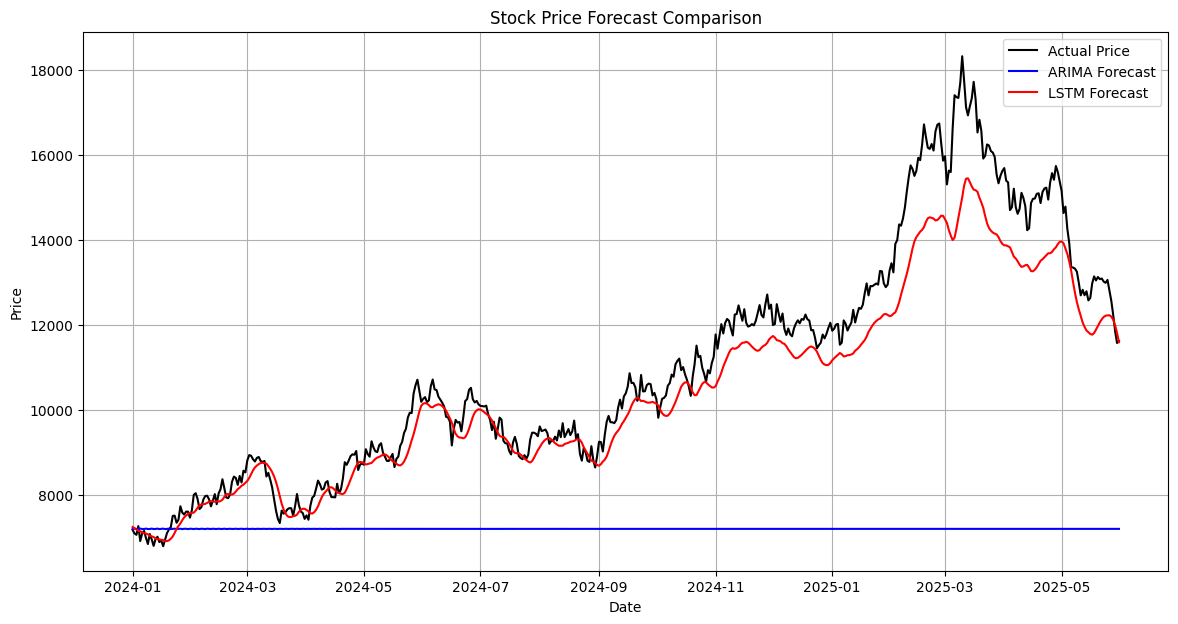

In [19]:
# Load data
data = load_data()

# Split data (chronological split)
train_data = data.loc['2015-01-01':'2023-12-31']
test_data = data.loc['2024-01-01':]

# Build ARIMA model with grid search
arima_pred, arima_conf, arima_order = build_arima(train_data, test_data)
print(f"\nBest ARIMA Order: {arima_order}")

# Build LSTM model
lstm_pred = build_lstm(train_data, test_data)

# Evaluate and compare models
evaluate_models(test_data, arima_pred, lstm_pred)